# config

In [1]:
max_article_count = 50
max_sentences_count = 10

In [2]:
import pandas as pd
import json
import os

# data

In [3]:
cache_path = "./caches/wikipedia_article_content_cache.json"

try:
    with open(cache_path, "r", encoding="utf-8") as f:
        wiki_cache = json.load(f)
except FileNotFoundError:
    wiki_cache = {}

In [4]:
new_cache_entries = {}

In [5]:
def load_search_cache(cache_path="./caches/search_result_cache.json"):
    """Loads search cache from JSON, converting string keys back to tuples."""

    if os.path.exists(cache_path):
        with open(cache_path, "r", encoding="utf-8") as f:
            try:
                raw_cache = json.load(f)
                # Convert stored string keys back to tuple format
                search_cache = {eval(key): value for key, value in raw_cache.items()}
            except (json.JSONDecodeError, SyntaxError):
                search_cache = {}  # Handle errors gracefully
    else:
        search_cache = {}  # Initialize an empty cache if the file doesn't exist

    return search_cache

# Load the cache at the beginning of your script
search_cache = load_search_cache()

In [6]:
with open("./caches/name_entities_cache.json", "r", encoding="utf-8") as f:
    text_name_entites_dict = json.load(f)

empty_sentence = []

fetch 20 samples of vast dataset

In [7]:
df = pd.read_json('./datasets/vast_new_dataset.json')
print("Total items in dataset:", len(df))

df_vast_test = df[
    df['source']
      .apply(lambda src_list: any(src.get('file') == 'vast_test.csv' for src in src_list))
].reset_index(drop=True)

print("Filtered items (dataset == 'vast test'):", len(df_vast_test))

sample_df = df_vast_test

Total items in dataset: 16373
Filtered items (dataset == 'vast test'): 2907


In [7]:
df = pd.read_json('./datasets/semeval_dataset.json')
print("Total items in dataset:", len(df))

# df_vast_test = df[
#     df['source']
#       .apply(lambda src_list: any(src.get('file') == 'SemEval-2016-Test.csv' for src in src_list))
# ].reset_index(drop=True)

print("Filtered items (dataset == 'semeval test'):", len(df))

sample_df = df

Total items in dataset: 4063
Filtered items (dataset == 'semeval test'): 4063


In [ ]:
df = pd.read_json('./datasets/pstance.json')
print("Total items in dataset:", len(df))

df_vast_test = df[
    df['source']
      .apply(lambda src_list: any('test' in src.get('file', '').lower() for src in src_list))
].reset_index(drop=True)

print("Filtered items (dataset == 'pstance test'):", len(df_vast_test))

sample_df = df_vast_test

In [ ]:
df = pd.read_json('./datasets/twitter_stance_election.json')
print("Total items in dataset:", len(df))

df_vast_test = df[
    df['source']
      .apply(lambda src_list: any('test' in src.get('file', '').lower() for src in src_list))
].reset_index(drop=True)

print("Filtered items (dataset == 'twitter_stance_election test'):", len(df_vast_test))

sample_df = df_vast_test

In [ ]:
df = pd.read_json('./datasets/gender_stance.json')
print("Total items in dataset:", len(df))

df_vast_test = df[
    df['source']
      .apply(lambda src_list: any('test' in src.get('file', '').lower() for src in src_list))
].reset_index(drop=True)

print("Filtered items (dataset == 'gender_stance test'):", len(df_vast_test))

sample_df = df_vast_test

In [8]:
text_lengths = sample_df['text'].dropna().str.len()  # Drop NaNs first if any

stats = {
    "Count": text_lengths.count(),
    "Mean": text_lengths.mean(),
    "Standard Deviation": text_lengths.std(),        # sample std dev
    "Variance": text_lengths.var(),                  # sample variance
    "Min": text_lengths.min(),
    "25% (Q1)": text_lengths.quantile(0.25),
    "Median (Q2)": text_lengths.median(),
    "75% (Q3)": text_lengths.quantile(0.75),
    "Max": text_lengths.max(),
    "Range": text_lengths.max() - text_lengths.min()
}

for key, value in stats.items():
    print(f"{key}: {value}")

Count: 4063
Mean: 108.6876692099434
Standard Deviation: 24.987553042417268
Variance: 624.3778070476164
Min: 34
25% (Q1): 92.0
Median (Q2): 117.0
75% (Q3): 130.0
Max: 142
Range: 108


# Knowledge Enrichment

## search topics in wikipedia

In [9]:
import wikipedia
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
import time


In [10]:
import os

def store_in_cache(title, page=None):
    data = {
        "content": getattr(page, "content", "") or "",
        "summary": getattr(page, "summary", "") or ""
    }
    # Single update for both caches
    new_cache_entries[title] = data

def flush_cache():
    if not new_cache_entries:
        return  # nothing to do

    # Merge and write
    wiki_cache.update(new_cache_entries)
    with open(cache_path, "w", encoding="utf-8") as f:
        json.dump(wiki_cache, f, ensure_ascii=False, indent=2)

    # Clear pending entries
    # new_cache_entries.clear()


def flush_name_entity_cache(new_entries, cache_path="./caches/name_entities_cache.json"):
    # Load existing cache if it exists
    if os.path.exists(cache_path):
        with open(cache_path, "r", encoding="utf-8") as f:
            try:
                existing_cache = json.load(f)
            except json.JSONDecodeError:
                existing_cache = {}
    else:
        existing_cache = {}

    # Merge new entries (without overwriting existing ones unless updated)
    existing_cache.update(new_entries)

    # Save the updated cache
    with open(cache_path, "w", encoding="utf-8") as f:
        json.dump(existing_cache, f, ensure_ascii=False, indent=2)


def update_search_cache(search_cache, cache_path="./caches/search_result_cache.json"):
    """Loads existing cache, converts tuple keys to strings, merges new entries, and saves the updated cache."""

    # Load existing cache if the file exists
    if os.path.exists(cache_path):
        with open(cache_path, "r", encoding="utf-8") as f:
            try:
                existing_cache = json.load(f)
            except json.JSONDecodeError:
                existing_cache = {}  # Handle corrupted JSON gracefully
    else:
        existing_cache = {}  # Initialize an empty cache if no prior data exists

    # Convert tuple keys in search_cache to strings for JSON compatibility
    formatted_cache = {str(key): value for key, value in search_cache.items()}

    # Merge new entries without overwriting unless updated
    existing_cache.update(formatted_cache)

    # Save the updated cache back to the file
    with open(cache_path, "w", encoding="utf-8") as f:
        json.dump(existing_cache, f, ensure_ascii=False, indent=2)

    # Clear search_cache to prevent duplicate processing
    # search_cache.clear()

In [11]:
def safe_fetch_page(title, retries: int = 1):
    """
    Try to fetch wikipedia.page(title).  
    - On DisambiguationError: auto‑fallback to first non‑cached option.
    - On JSON decode / network error: retry once then give up.
    Returns:
      WikipediaPage on success,
      None on permanent failure.
    """
    try:
        time.sleep(0.1)
        content = wikipedia.page(title, auto_suggest=False)
        time.sleep(0.1)
        return content
    except wikipedia.DisambiguationError as e:
        opts = e.options[:10]
        new_cache_entries[title] = {'disambiguation': opts}
        for opt in opts:
            if opt.lower() != title.lower():
                try:
                    time.sleep(0.1)
                    opt_content = wikipedia.page(opt, auto_suggest=False)
                    time.sleep(0.1)
                    return opt_content
                except Exception:
                    continue
        return None
    except Exception as e:
        # retry once on transient errors
        if retries > 0 and "Expecting value" in str(e):
            time.sleep(1)
            return safe_fetch_page(title, retries - 1)
        return None

In [12]:
def fetch_page_content(wiki_title, search_results=None):
    """
    Return the page content for wiki_title, using the local cache if available.
    - If wiki_title in cache with 'content', returns that.
    - If wiki_title in cache with 'disambiguation', picks a fallback and returns its content.
    - Otherwise, returns empty string (no live fetch).
    """
    # 1) Direct content hit
    entry = wiki_cache.get(wiki_title) or new_cache_entries.get(wiki_title)

    if isinstance(entry, dict) and "content" in entry:
        return entry["content"] or ""

    # 2) Disambiguation hit
    if isinstance(entry, dict) and "disambiguation" in entry:
        # list of fallback titles
        opts = entry["disambiguation"]
        # pick first that is not in search_results
        for opt in opts:
            if not search_results or opt not in search_results:
                # check cache for the fallback page
                fb_entry = wiki_cache.get(opt, {})
                if "content" in fb_entry:
                    return fb_entry["content"] or ""
        return ""  # none found

    page = safe_fetch_page(wiki_title)
    if page:
        # record new cache entry
        store_in_cache(wiki_title, page)
        return page.content or ""
    else:
        # record empty so we don't retry endlessly
        store_in_cache(wiki_title)
        return ""
    # 3) Not in cache → no content
    return ""

In [13]:
def process_and_fetch_page_content(wiki_title, search_results):        
    try:
        content = fetch_page_content(wiki_title, search_results)

        if content == "":
            return ""
        
        # Define a list of unwanted section headings
        unwanted_sections = [
            "External links",
            "Further reading",
            "Etymology",
            "Others",
            "See also",
            "Notes",
            "References",
            "Book references",
            "Journal references",
            "News references",
            "Web references"
        ]
        
        # Create a regex pattern that matches a section heading.
        # Using re.escape to be safe with any special characters.
        pattern = r"\n==\s*(" + "|".join(re.escape(section) for section in unwanted_sections) + r")\s*=="
        
        # Split the content at the first occurrence of any unwanted section
        cleaned_content = re.split(pattern, content, flags=re.IGNORECASE)[0].strip()

        cleaned_content = re.sub(
            r'(?m)^\s*=+\s*.+?\s*=+\s*$',
            '',
            cleaned_content
        )

        # 3) Collapse multiple blank lines into two
        cleaned_content = re.sub(r'\n{2,}', '\n\n', cleaned_content).strip()
        
        return cleaned_content
    
    except Exception as e:
        print(f"Error fetching Wikipedia page: '{wiki_title}': {e}")
        return ""

In [14]:
def fetch_wikipedia_articles_knowledge (topic, max_result=25):
    page_content_array = []
    try:
        cache_key = (topic, max_result)
        if cache_key in search_cache:
            search_results = search_cache[cache_key]
            if search_results and search_results[0] == "##NR##":
               if search_results[1] % 7 != 0:
                search_cache[cache_key] = ["##NR##", (search_results[1] + 1) % 7]
                return page_content_array
        else:
            search_results = wikipedia.search(topic, results=max_result)
            search_cache[cache_key] = search_results
            print(f"ℹ️ search results for: {topic}")

        if search_results:
            with ThreadPoolExecutor(max_workers=10) as executor:
                futures = {executor.submit(process_and_fetch_page_content, title, search_results): title for title in search_results}
                for future in as_completed(futures):
                    title = futures[future]
                    try:
                        page_text = future.result()
                        if page_text:
                            page_content_array.append(page_text)
                    except Exception as e:
                        print(f"⚠️  Error fetching '{title}': {e}")        
        else:
            print(f"❌ No results found for this topic. {topic}, save ##NR##")
            search_cache[cache_key] = ["##NR##", 1]

    except Exception as e:
        print(f"❌ Error fetching Wikipedia content for '{topic}': {e}")
        return page_content_array

    return page_content_array

## use GPT as name entity extractor

In [1]:
import openai
import time

In [ ]:
gpt_client = openai.OpenAI(api_key='sk-proj-x8tJ7sJDi****Yn2-tyoU09qbjYReGEA')
deep_seek_client = openai.OpenAI(
        api_key="sk-86d8****b2fb7",
        base_url="https://api.deepseek.com"
    )
llama_client = openai.OpenAI(
        api_key="eyJhbGciOiJI*****AWWCTNAsYGI5X9re1BlHkVWEJv8NzHA0PnqJtUQ",
        base_url="https://ai.liara.ir/api/v1/689f32c5ae44771a3463a362"
    )

In [5]:
# --- 1) GPT-4o mini via OpenAI ---

def prompt_llm_gpt4omini(text, system_text):
    response = gpt_client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_text},
            {"role": "user", "content": text}
        ],
        max_tokens=100,
        temperature=0
    )
    try:
        content = response.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error parsing gpt response: {e}")
        content = "Error"
    time.sleep(0.1)
    return content

In [6]:
# --- 2) DeepSeek (your snippet) ---

def prompt_llm_deepseek(text, system_text):
    response = deep_seek_client.chat.completions.create(
        model='deepseek-chat',
        messages=[
            {"role": "system", "content": system_text},
            {"role": "user", "content": text}
        ],
        max_tokens=500,
        temperature=0
    )
    try:
        content = response.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error parsing DeepSeek response: {e}")
        content = "Error"
    time.sleep(0.1)
    return content

In [7]:
# --- 3) LLaMA 3.3 70B via Hugging Face Hub (your snippet adapted, non-streaming) ---

def prompt_llm_llama(text, system_text):
    response = llama_client.chat.completions.create(
        model='meta-llama/llama-3.3-70b-instruct',
        messages=[
            {"role": "system", "content": system_text},
            {"role": "user", "content": text}
        ],
        max_tokens=500,
        temperature=0
    )
    try:
        content = response.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error parsing DeepSeek response: {e}")
        content = "Error"
    time.sleep(0.1)
    return content

In [17]:
# --- 3) Google: Gemini 2.0 Flash via Hugging Face Hub (your snippet adapted, non-streaming) ---

def prompt_llm_gemini(text, system_text):
    response = llama_client.chat.completions.create(
        model='google/gemini-2.0-flash-001',
        messages=[
            {"role": "system", "content": system_text},
            {"role": "user", "content": text}
        ],
        max_tokens=500,
        temperature=0
    )
    try:
        content = response.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error parsing gemeni response: {e}")
        content = "Error"
    time.sleep(0.1)
    return content

In [20]:
import re
import time

def old_extract_entities(text):
    prompt = f"""Identify and tag named entities in the following text with sequential entity tags. 
Use the format <e1>Entity1</e1>, <e2>Entity2</e2>, <e3>Entity3</e3>, etc. 
Each entity should have a distinct tag (e1, e2, e3, etc.).

Text:
"{text}"

Output only the modified text with tagged entities."""
    system_text = "You are an expert name entity extractor."
    
    tagged_text = prompt_llm_gpt4omini(prompt, system_text)

    try:
        # extract and lowercase all entity contents inside <e*>...</e*>
        entities = [e.lower() for e in re.findall(r'<e\d+>(.*?)</e\d+>', tagged_text)]
        if not entities:
            entities = ["##NR##" , 0]
    except Exception as e:
        print(f"Error parsing response: {e}")
        entities = []

    time.sleep(0.02)
    return entities


## filter paragraphs contains name entities

In [21]:
from nltk import download, sent_tokenize
from nltk.tokenize import word_tokenize

download('punkt')
download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alire\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\alire\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [22]:
import re

def filter_sentences_by_entities(
    sentences, 
    named_entities, 
    target, 
    max_sentences=20, 
    minimum_mached_entity_count=1,
    min_entity_coverage=0  # New: ratio of named entities required
):
    scored_sentences = []

    # Pre‑compile a regex to strip the target as a whole word
    target_pattern = re.compile(rf"\b{re.escape(target.lower())}")

    # Filter and compile entity patterns, skipping 1-character entities
    entity_patterns = {
        entity.lower(): re.compile(rf"\b{re.escape(entity.lower())}")
        for entity in named_entities
        if len(entity.strip()) > 1
    }

    total_entity_count = len(entity_patterns)

    for sent in sentences:
        sent_lower = sent.lower()

        # 1. Remove the target entirely
        sent_no_target = target_pattern.sub("", sent_lower)

        # 2. Score entities in the cleaned text
        entity_score = 0
        matched_entity_count = 0
        for entity, pat in entity_patterns.items():
            matches = pat.findall(sent_no_target)
            entity_score += len(matches) * len(entity)
            if matches:
                matched_entity_count += 1
  
        if entity_score == 0:
            continue  # skip sentences with no entity hits

        if matched_entity_count < minimum_mached_entity_count:
            continue

        if total_entity_count > 0:
            coverage_ratio = matched_entity_count / total_entity_count
            if coverage_ratio < min_entity_coverage:
                continue

        # 3. Normalize by sentence length (post‑removal)
        length = len(sent_no_target) or 1
        score = entity_score / length

        scored_sentences.append((sent, score))

    # 4. Return the top‑scoring sentences
    scored_sentences.sort(key=lambda x: x[1], reverse=True)
    return [sent for sent, _ in scored_sentences[:max_sentences]]


In [23]:
import re
from nltk.tokenize import sent_tokenize

def sentence_extraction(target, content_array):
    if not target or not isinstance(target, str):
        return []

    # Compile a case-insensitive, whole-word pattern for the target
    pattern = re.compile(rf"\b{re.escape(target)}", flags=re.IGNORECASE)

    sentences = []
    for content in content_array:
        if not content or not isinstance(content, str):
            continue
        for sent in sent_tokenize(content):
            # If the pattern matches anywhere in the sentence, keep it
            if pattern.search(sent):
                sentences.append(sent)
    return sentences


## flow function

In [25]:
import ast
import json


def new_knowledge_enrichment(text, target, config):
    # مرحله اول: گرفتن محتوای ویکی‌پدیا برای تارگت به صورت لیست
    related_page_contents = fetch_wikipedia_articles_knowledge(
        target, config.get('max_article_count', 25)
    )

    # تلاش برای دریافت موجودیت‌ها از کش یا تبدیل JSON
    text_name_entities_str = text_name_entites_dict.get(text, [])

    if isinstance(text_name_entities_str, str) and text_name_entities_str.startswith("["):
        try:
            text_name_entities = json.loads(text_name_entities_str)
            print(f"✅ JSON load success: {text_name_entities_str}")
        except json.JSONDecodeError:
            print(f"⚠️ Error decoding JSON for: {text_name_entities_str}")
            text_name_entities = []
    else:
        text_name_entities = text_name_entities_str
        
    if not text_name_entities or text_name_entities == ["##NR##"]:
        print(f"🔍 Extracting entities from raw text.")
        text_name_entities = old_extract_entities(text)

    text_name_entities = list(dict.fromkeys(text_name_entities))  # حذف تکراری‌ها
    if text_name_entities and text_name_entities[0] == "##NR##":
        print("saved", text_name_entities)
        text_name_entites_dict[text] = ["##NR##" , (text_name_entities[1] + 1) % 7]
    else:
        text_name_entites_dict[text] = text_name_entities   # ذخیره در کش

    if text_name_entities and text_name_entities[0] == "##NR##":
        text_name_entities = []
    # مرحله دوم: واکشی ویکی‌پدیا برای هر موجودیت و اضافه کردن به آرایه
    for entity in text_name_entities:
        try:
            entity_contents = fetch_wikipedia_articles_knowledge(
                entity, config.get('max_article_count', 25)
            )
            if isinstance(entity_contents, list):
                related_page_contents.extend(entity_contents)
            else:
                print(f"⚠️ Skipping entity '{entity}' – result is not a list")
        except Exception as e:
            print(f"⚠️ Failed to fetch content for entity '{entity}': {e}")

    # مرحله سوم: استخراج و فیلتر جملات دانش
    content_sentences = sentence_extraction(target, related_page_contents)
    knowledge_sentences_array = filter_sentences_by_entities(
        content_sentences,
        text_name_entities,
        target,
        config.get('max_sentences_count', 10),
        config.get('minimum_entity_count', 1),
        config.get('min_entity_coverage', 0)
    )

    return knowledge_sentences_array, text_name_entities

# use GPT as verbalizer

In [ ]:
def ask_all(prompt, sysyem_text):
    with ThreadPoolExecutor(max_workers=3) as executor:
        futures = {
            "gpt-4o-mini": executor.submit(prompt_llm_gpt4omini, prompt, sysyem_text),
            "deepSeek-V3-0324": executor.submit(prompt_llm_deepseek, prompt, sysyem_text),
            "llama-3.3-70b": executor.submit(prompt_llm_llama, prompt, sysyem_text),
            "gemini-2.0-flash": executor.submit(prompt_llm_gemini, prompt, sysyem_text),
        }
        results = {}
        for name, future in futures.items():
            try:
                # [0] because your functions return (response, text)
                results[name] = future.result()
            except Exception as e:
                results[name] = f"Error: {e}"
        return results

In [27]:
def prompt_llm(text, target):
    prompt = f'''The task is Stance Detection. Determine the stance of the input text towards the specified target. The stance can be one of: FAVOR, AGAINST, or NONE.

Input Text: {text}
Target: {target}'''
    system_text = "You are an expert in stance detection.output structure is [stance label]-[reason of choosing] stance label is one of: FAVOR, AGAINST, or NONE (uppercase)"

    response = ask_all(prompt, system_text)
    try:
        predicted_stance = response.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error parsing response: {e}")
        predicted_stance = "Error-Error"
    time.sleep(0.02)
    return predicted_stance.upper(), prompt

In [28]:
def prompt_llm_knowledge(text, target, knowledge):
    prompt = f'''Your task is Stance Detection. Consider the sequential concepts which appear in the unput text and Determine the stance of the author of input text towards the specified target in general. Use the provided knowledge context related to the target and name entities in the input text as factual background to enhance reasoning and support your decision. The stance can be one of: FAVOR, AGAINST, or NONE.
Input Text: {text}
Target: {target}
Knowledge context: 
{knowledge}'''
    system_text = "You are an expert in stance detection.output structure is [stance label]-[reason of choosing] stance label is one of: FAVOR, AGAINST, or NONE (uppercase)"
    try:    
        response = prompt_llm_gpt4omini(prompt, system_text)
    except Exception as e:
        print(f"Error parsing response: {e}")
        response = "Error - Error"
    time.sleep(0.1)
    return response.upper(), prompt

# FLOW

In [ ]:
# 2. VERSION 1 BASE
verbalization_logs = []
i = 0
start_time = time.perf_counter()
last_log_time = start_time 
for idx, row in sample_df.iterrows():  # pandas.DataFrame.iterrows
    text = row['text']
    target = row['target']        

    # verbalizer
    final_result, prompt = prompt_llm(text=text, target=target)
    final_label = final_result.split("-")[0]
    final_reason = final_result.split("-")[1]
    
    # loging
    verbalization_logs.append({
        "text": text,
        "target": target,
        "prompt": prompt.strip(),
        "final_label": final_label.strip(),
        "ai reason":final_reason.strip(),
        "correct_label": row["stance"].strip(),
    })

    # 3. Print neatly

    if i % 100 == 0:
        current_time = time.perf_counter()
        total_elapsed = current_time - start_time
        last_elapsed = current_time - last_log_time
        print(f"{i} DONE - Total time: {total_elapsed:.2f}s, Since last: {last_elapsed:.2f}s")
        last_log_time = current_time
    i = i + 1

In [ ]:
# 2. VERSION 2
verbalization_logs = []
i = 0
start_time = time.perf_counter()
last_log_time = start_time 
for idx, row in sample_df.iterrows():  # pandas.DataFrame.iterrows
    text = row['text']
    target = row['target']

    # knowledge enrichment
    config = {'max_article_count': 50, 
              'max_sentences_count': 10, 
              'minimum_entity_count':1,
              'min_entity_coverage':0}
    knowledge_array, name_entites = new_knowledge_enrichment(
        text, target, config)
    knowledge = f" ".join(knowledge_array)

    
    # verbalizer
    final_result, prompt = prompt_llm_knowledge(text=text, target=target, knowledge=knowledge)
    final_result, prompt = prompt_llm(text=text, target=target)
    final_label = final_result.split("-")[0]
    final_reason = final_result.split("-")[1]
    
    # loging
    verbalization_logs.append({
        "text": text,
        "target": target,
        "name_entities":name_entites,
        "knowledge": knowledge,
        "prompt": prompt.strip(),
        "final_label": final_label.strip(),
        "ai reason":final_reason.strip(),
        "correct_label": row["stance"].strip(),
    })

    # 3. Print neatly

    if i % 100 == 0:
        current_time = time.perf_counter()
        total_elapsed = current_time - start_time
        last_elapsed = current_time - last_log_time
        print(f"{i} DONE - Total time: {total_elapsed:.2f}s, Since last: {last_elapsed:.2f}s")
        last_log_time = current_time

    if i % 400 == 0:
        flush_cache()
        flush_name_entity_cache(text_name_entites_dict)
        update_search_cache(search_cache)
        print("......................ceche saved successfully..........................")
        
    i = i + 1

In [30]:
    # Load previous results if available
resume_file = "verbalization_results_article_count_0_3600.xlsx"
if os.path.exists(resume_file):
    processed_df = pd.read_excel(resume_file)
    verbalization_logs = processed_df.to_dict(orient="records")
    start_index = len(processed_df)
    print(f"Resuming from index {start_index}")
else:
    verbalization_logs = []
    start_index = 0
    print("Starting from scratch")

start_time = time.perf_counter()
last_log_time = start_time

for i in range(start_index, len(sample_df)):
    row = sample_df.iloc[i]
    text = row['text']
    target = row['target']

    config = {'max_article_count': 50, 
              'max_sentences_count': 10, 
              'minimum_entity_count':1,
              'min_entity_coverage':0}
    knowledge_array, name_entites = new_knowledge_enrichment(
        text, target, config)
    knowledge = f" ".join(knowledge_array)

    prompt = f'''Your task is Stance Detection. Consider the sequential concepts which appear in the unput text and Determine the stance of the author of input text towards the specified target in general. Use the provided knowledge context related to the target and name entities in the input text as factual background to enhance reasoning and support your decision. The stance can be one of: FAVOR, AGAINST, or NONE.
Input Text: {text}
Target: {target}
Knowledge context: 
{knowledge}'''
    SYSTEM_PROMPT = "You are an expert in stance detection.output structure is [stance label]-[reason of choosing] stance label is one of: FAVOR, AGAINST, or NONE (uppercase)"


    results = ask_all(prompt , SYSTEM_PROMPT)

    split_results = {}
    for model_name, output in results.items():
        if "-" in output:
            stance, reason = output.split("-", 1)
            stance = stance.strip()
            reason = reason.strip()
        else:
            stance, reason = output.strip(), ""
        
        split_results[f"{model_name}_stance"] = stance
        split_results[f"{model_name}_reason"] = reason

    verbalization_logs.append({
        "text": text,
        "target": target,
        **split_results,
        "prompt": prompt.strip(),
        "source": row["source"][0]['file'],
        "correct_label": row["stance"].strip(),
    })
    print(i)
    if i % 100 == 0:
        current_time = time.perf_counter()
        total_elapsed = current_time - start_time
        last_elapsed = current_time - last_log_time
        print(
            f"{i} DONE - Total time: {total_elapsed:.2f}s, Since last: {last_elapsed:.2f}s")
        last_log_time = current_time

    if i % 200 == 0:
        temp_df = pd.DataFrame(verbalization_logs)
        name = f"verbalization_results_article_count_0_{i}.xlsx"
        temp_df.to_excel(name, index=False)
        print("-----------------------saved results--------------------------")

    i = i + 1

Resuming from index 3601


d:\Alireza\تز ارشد\فایل‌های پایان‌نامه\پیاده سازی\stance detection using wikipedia augmented data\venv\Lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file d:\Alireza\تز ارشد\فایل‌های پایان‌نامه\پیاده سازی\stance detection using wikipedia augmented data\venv\Lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
Error fetching Wikipedia page: 'Philip Robertson': HTTPSConnectionPool(host='en.wikipedia.org', port=443): Max retries exceeded with url: /w/api.php?prop=extracts&explaintext=&exintro=&titles=Philip+Robertson+%28British+Army+officer%29&format=json&action=query (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000223699C4CE0>, 'Connection to en.wikipedia.org timed out. (connect timeout=None)'))
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3700 DONE - Total time: 2491.27s, Since last: 2491.27s
3701
3702
saved [

# Save

In [33]:
import random
import json

In [31]:
flush_cache()
flush_name_entity_cache(text_name_entites_dict)
update_search_cache(search_cache)

In [34]:
verbalization_df = pd.DataFrame(verbalization_logs)

# Save to Excel
random_float = random.random()
try:
    name = f"verbalization_results_article_count_{config['max_article_count']}_sentences_count_{config['max_sentences_count']}_{random_float}.xlsx"
except NameError:
    name = f"verbalization_results_article_count_{random_float}.xlsx"
verbalization_df.to_excel(name, index=False)

print(f"Saved verbalization results to '{name}'")

Saved verbalization results to 'verbalization_results_article_count_50_sentences_count_10_0.7417060351521996.xlsx'


# analyze

In [1]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_recall_fscore_support
)
import matplotlib.pyplot as plt

In [2]:
# Extract true & predicted
y_true = verbalization_df['correct_label']
y_pred = verbalization_df['final_label']

# Choose label order
labels = ['FAVOR', 'AGAINST', 'NONE']

# Compute metrics
cm = confusion_matrix(y_true, y_pred, labels=labels)
acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=labels, zero_division=0)
f1_weighted = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)[2]

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax, colorbar=True)
ax.set_title('Confusion Matrix (Blue)')

# Annotate all metrics
metrics_text = (
    f"Accuracy: {acc:.2%}\n\n"
    f"Label --- Prec - Recall - F1\n"
    f"FAVOR --- {prec[0]:.2%} - {rec[0]:.2%} - {f1[0]:.2%}\n"
    f"AGAINST - {prec[1]:.2%} - {rec[1]:.2%} - {f1[1]:.2%}\n"
    f"NONE ---- {prec[2]:.2%} - {rec[2]:.2%} - {f1[2]:.2%}\n\n"
    f"Weighted F1: {f1_weighted:.2%}"
)

# Position metrics below the plot
fig.text(0.01, -0.05, metrics_text, fontsize=11, va='top', family='monospace')

plt.tight_layout()
plt.show()


NameError: name 'verbalization_df' is not defined

# word export

In [ ]:
import pandas as pd
from docx import Document
from docx.shared import RGBColor
import json

In [2]:
import pandas as pd
from docx import Document
from docx.shared import RGBColor
import ast
import re

def export_random_examples_to_word(
    excel_path: str,
    sheet_name=0,
    columns: list = None,
    n: int = 10,
    output_docx: str = "sample_examples.docx",
    random_state: int = 42,
    condition=None,
    sort_by: str = None,
    ascending: bool = True,
    take_first: bool = False
):
    """
    Export n rows from an Excel sheet to a Word document,
    after optional filtering and sorting.

    Parameters
    ----------
    condition : str or callable, optional
        - If str: a pandas query string, e.g. "sentiment == 'NEGATIVE'".
        - If callable: function(df) -> boolean Series to filter rows.
    sort_by : str, optional
        Column name to sort by before selecting rows.
    ascending : bool, default True
        Sort order: True for ascending, False for descending.
    take_first : bool, default False
        If True, take the first n rows after filtering/sorting instead of sampling.
    """
    # Load Excel
    df = pd.read_excel(excel_path, sheet_name=sheet_name)
    if isinstance(df, dict):
        df = next(iter(df.values()))

    # Subset columns
    if columns is not None:
        missing = set(columns) - set(df.columns)
        if missing:
            raise ValueError(f"Columns not found: {missing}")
        df = df[columns]

    # Apply filter condition
    if condition is not None:
        if isinstance(condition, str):
            df = df.query(condition)
        elif callable(condition):
            mask = condition(df)
            if not isinstance(mask, pd.Series) or mask.dtype != bool:
                raise ValueError("Callable condition must return boolean Series.")
            df = df.loc[mask]
        else:
            raise ValueError("`condition` must be a query string or callable.")

    # Sort if requested
    if sort_by is not None:
        if sort_by not in df.columns:
            raise ValueError(f"sort_by column '{sort_by}' not found in DataFrame.")
        df = df.sort_values(by=sort_by, ascending=ascending)

    # Ensure enough rows
    if len(df) < n:
        raise ValueError(
            f"Not enough rows after filtering/sorting: {len(df)} available, {n} requested."
        )

    # Select rows: sample or take first
    if take_first:
        sample_df = df.head(n)
    else:
        sample_df = df.sample(n=n, random_state=random_state)

    # Build Word document
    doc = Document()
    title = f"{n} {'First' if take_first else 'Random'} Examples from {excel_path}"
    doc.add_heading(title, level=1)

    for idx, row in sample_df.iterrows():
        doc.add_heading(f"Example index {idx}", level=2)

        # Extract entities
        entities = []
        entity_lower = set()
        if 'name_entities' in row.index:
            try:
                ents = ast.literal_eval(row['name_entities'])
            except Exception:
                ents = []
            seen = set()
            for e in ents:
                e_strip = e.strip()
                if e_strip and e_strip.lower() not in seen:
                    seen.add(e_strip.lower())
                    entities.append(e_strip)
            entities = sorted(entities, key=len, reverse=True)
            entity_lower = set(e.lower() for e in entities)

        # Process each column
        for col in sample_df.columns:
            para = doc.add_paragraph()
            run = para.add_run(f"{col}: ")
            run.bold = True
            cell = str(row[col])

            if col == 'sentence_sentiments':
                parts = [cell]
                if entities:
                    pattern = re.compile(r'(' + '|'.join(map(re.escape, entities)) + r')', flags=re.IGNORECASE)
                    parts = re.split(pattern, cell)
                for part in parts:
                    if part.lower() in entity_lower:
                        r = para.add_run(part)
                        r.font.color.rgb = RGBColor(0x00, 0x00, 0xFF)
                    else:
                        for sp in re.split(r'(NEGATIVE|POSITIVE|NEUTRAL)', part, flags=re.IGNORECASE):
                            if sp.upper() in ['NEGATIVE','POSITIVE','NEUTRAL']:
                                col_map = {'NEGATIVE': RGBColor(0xFF,0x00,0x00),
                                           'POSITIVE': RGBColor(0x00,0xFF,0x00),
                                           'NEUTRAL': RGBColor(0xFF,0x80,0x00)}
                                r = para.add_run(sp)
                                r.font.color.rgb = col_map[sp.upper()]
                            else:
                                para.add_run(sp)

            elif col == 'text' and entities:
                pattern = re.compile(r'(' + '|'.join(map(re.escape, entities)) + r')', flags=re.IGNORECASE)
                for part in re.split(pattern, cell):
                    if part.lower() in entity_lower:
                        r = para.add_run(part)
                        r.font.color.rgb = RGBColor(0x00, 0x00, 0xFF)
                    else:
                        para.add_run(part)

            else:
                para.add_run(cell)

        doc.add_paragraph()

    # Save
    doc.save(output_docx)
    print(f"Wrote {n} {'first' if take_first else 'random'} examples to {output_docx}")


In [ ]:
export_random_examples_to_word(
    excel_path=name,
    columns=["text", "target", "name_entities", "sentence_sentiments", "final_label", "correct_label", "ai reason"],
    n=50,
    output_docx="sample_stance_examples.docx"
)

# analyse df

🔎 Debug info:
  Rows in model file    : 1249
  Rows in baseline file : 1249
  Rows after merge      : 1249
--------------------------------------------------
gpt-4o-mini_stance: invalid labels → Model=0, Baseline=0


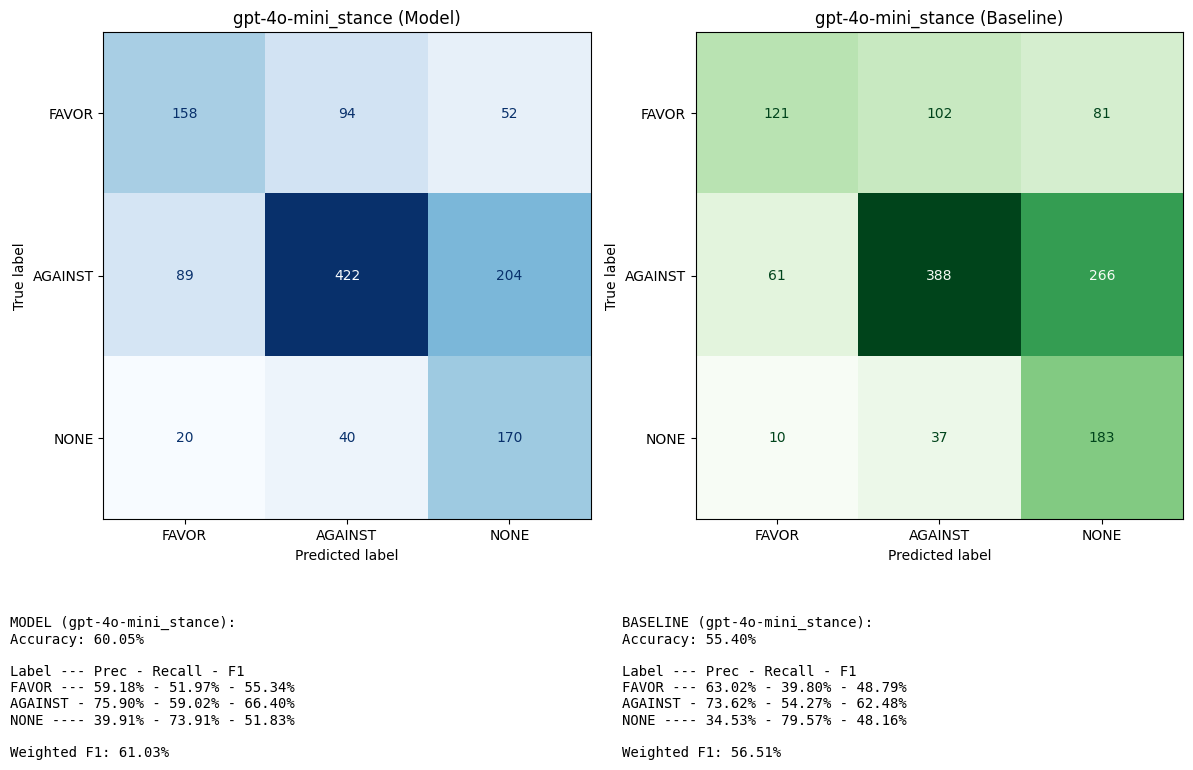

deepSeek-V3-0324_stance: invalid labels → Model=0, Baseline=0


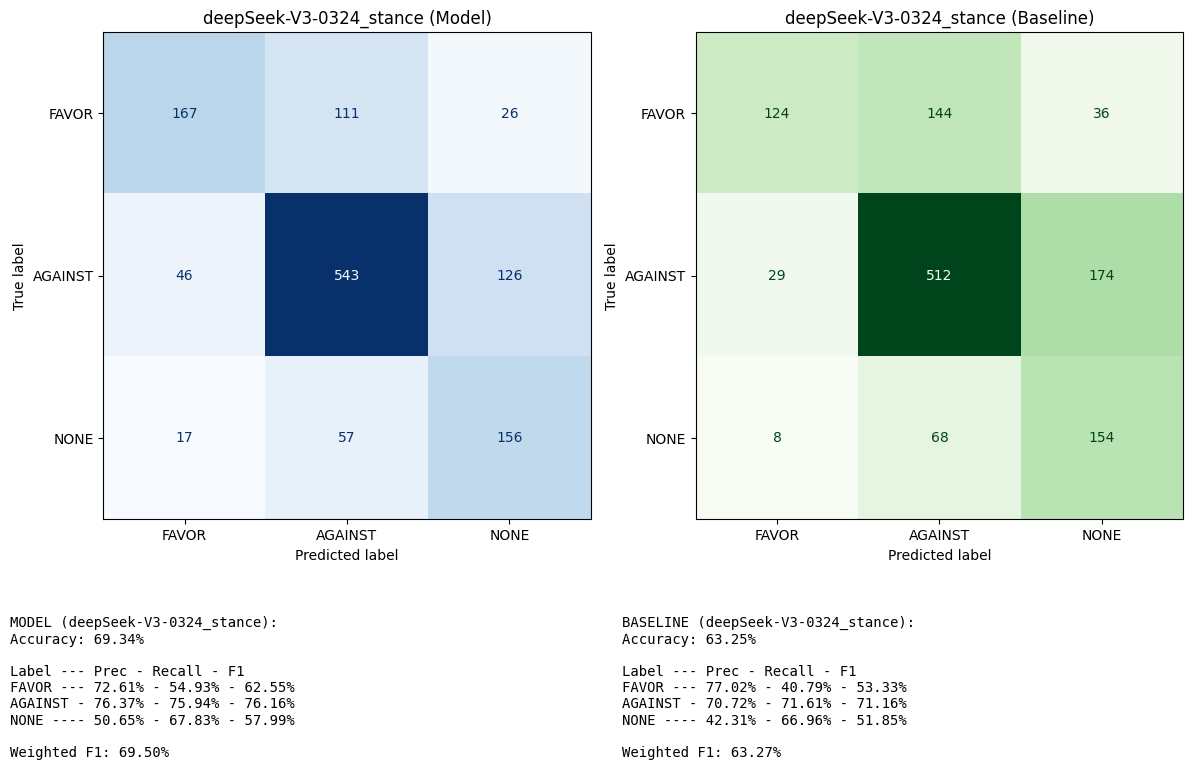

llama-3.3-70b_stance: invalid labels → Model=0, Baseline=0


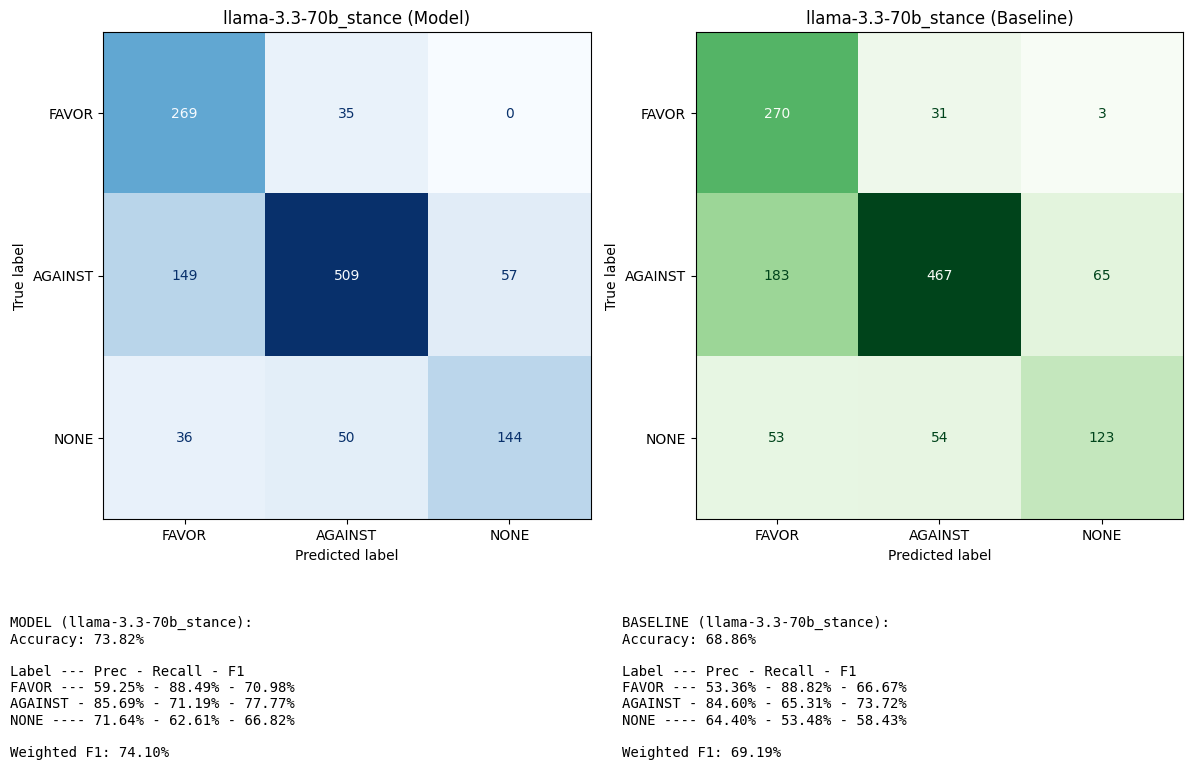

gemini-2.0-flash_stance: invalid labels → Model=0, Baseline=0


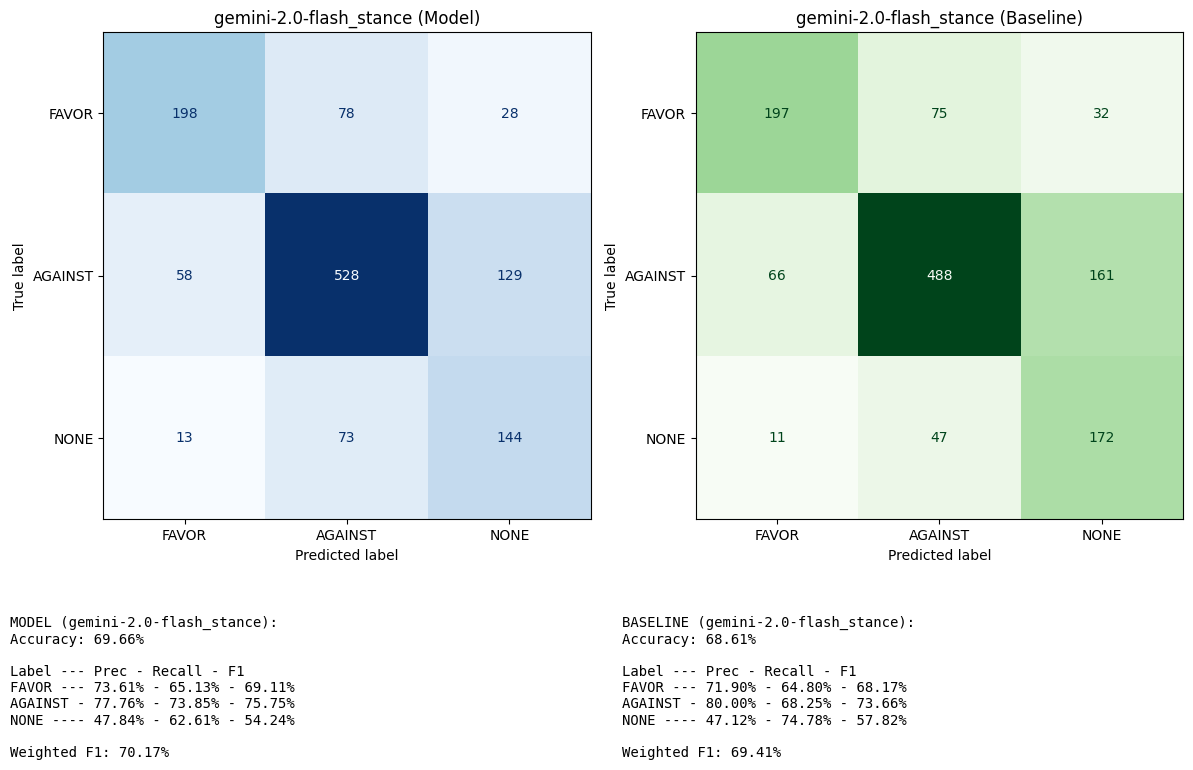

qwen_stance: invalid labels → Model=0, Baseline=0


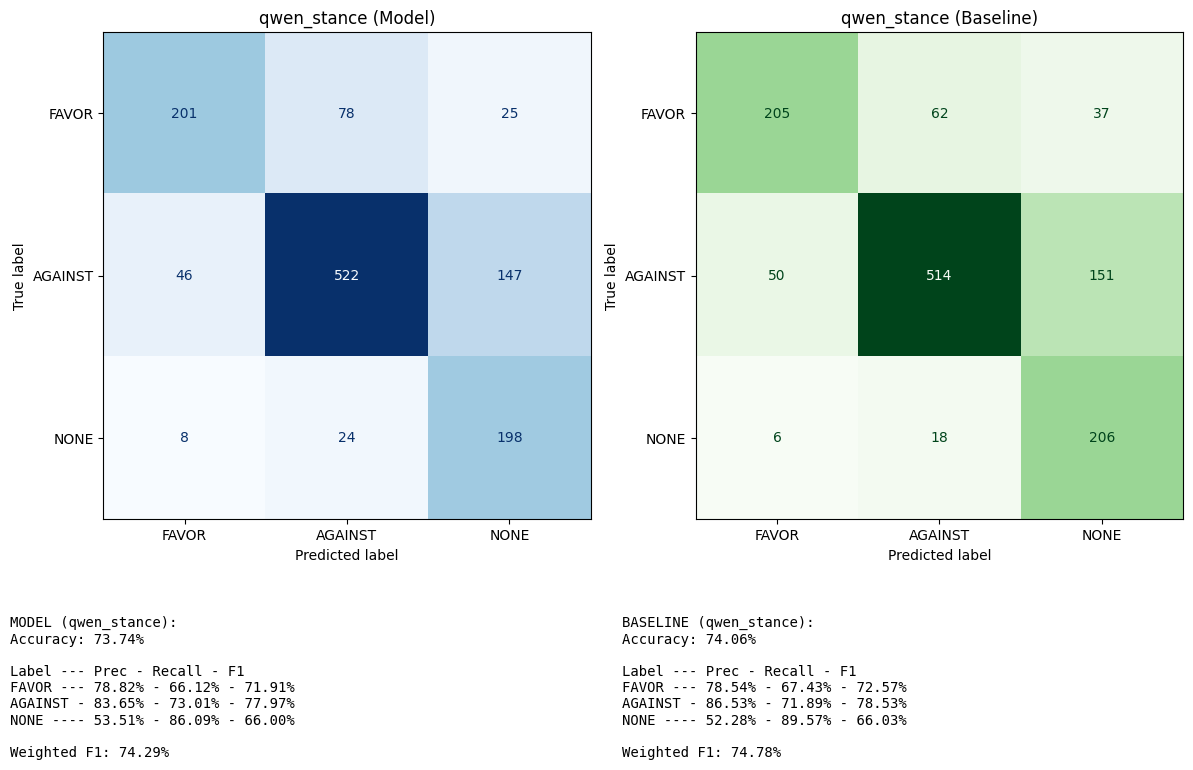

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

# --- خواندن فایل‌ها ---
adf = pd.read_excel("qwen_recomputed_with_all.xlsx")
baseline_df = pd.read_excel("llama-gpt-deepseek-gemini-qwen-semeval-baseline.xlsx")

# --- فقط ردیف‌های تست ---
adf = adf[adf["source"] == "SemEval-2016-Test.csv"].copy()
baseline_df = baseline_df[baseline_df["source"] == "SemEval-2016-Test.csv"].copy()

# --- پاکسازی متن برای merge ---
for df in [adf, baseline_df]:
    df["text"] = df["text"].astype(str).str.strip()
    df["source"] = df["source"].astype(str).str.strip()

# --- merge ---
df = pd.merge(adf, baseline_df, on=["text", "correct_label", "source"], suffixes=("_model", "_baseline"))

print("🔎 Debug info:")
print(f"  Rows in model file    : {len(adf)}")
print(f"  Rows in baseline file : {len(baseline_df)}")
print(f"  Rows after merge      : {len(df)}")
print("-" * 50)

# --- ستون‌های مدل‌ها ---
model_columns = [
    "gpt-4o-mini_stance",
    "deepSeek-V3-0324_stance",
    "llama-3.3-70b_stance",
    "gemini-2.0-flash_stance",
    "qwen_stance"
]

labels = ["FAVOR", "AGAINST", "NONE"]
valid_labels = set(labels)

def compute_metrics(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, zero_division=0
    )
    f1_weighted = precision_recall_fscore_support(
        y_true, y_pred, average="weighted", zero_division=0
    )[2]

    metrics_text = (
        f"Accuracy: {acc:.2%}\n\n"
        f"Label --- Prec - Recall - F1\n"
        f"FAVOR --- {prec[0]:.2%} - {rec[0]:.2%} - {f1[0]:.2%}\n"
        f"AGAINST - {prec[1]:.2%} - {rec[1]:.2%} - {f1[1]:.2%}\n"
        f"NONE ---- {prec[2]:.2%} - {rec[2]:.2%} - {f1[2]:.2%}\n\n"
        f"Weighted F1: {f1_weighted:.2%}"
    )
    return cm, metrics_text

for model in model_columns:
    y_true = df["correct_label"]

    # گرفتن پیش‌بینی‌ها
    y_pred_model = df[f"{model}_model"].astype(str).str.strip()
    y_pred_base = df[f"{model}_baseline"].astype(str).str.strip()

    # شمارش invalidها
    invalid_model = (~y_pred_model.isin(valid_labels)).sum()
    invalid_base = (~y_pred_base.isin(valid_labels)).sum()
    print(f"{model}: invalid labels → Model={invalid_model}, Baseline={invalid_base}")

    # جایگزینی invalid با NONE
    y_pred_model = y_pred_model.apply(lambda x: x if x in valid_labels else "NONE")
    y_pred_base = y_pred_base.apply(lambda x: x if x in valid_labels else "NONE")

    # متریک‌ها
    cm_model, text_model = compute_metrics(y_true, y_pred_model, labels)
    cm_base, text_base = compute_metrics(y_true, y_pred_base, labels)

    # دو نمودار کنار هم
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    ConfusionMatrixDisplay(confusion_matrix=cm_model, display_labels=labels).plot(cmap="Blues", ax=axes[0], colorbar=False)
    axes[0].set_title(f"{model} (Model)")

    ConfusionMatrixDisplay(confusion_matrix=cm_base, display_labels=labels).plot(cmap="Greens", ax=axes[1], colorbar=False)
    axes[1].set_title(f"{model} (Baseline)")

    # متریک‌ها زیر نمودار
    fig.text(0.01, -0.05, f"MODEL ({model}):\n{text_model}", fontsize=10, va="top", family="monospace")
    fig.text(0.52, -0.05, f"BASELINE ({model}):\n{text_base}", fontsize=10, va="top", family="monospace")

    plt.tight_layout()
    plt.show()


In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# -----------------------
# 1. Load the dataset
# -----------------------
df = pd.read_excel("llama-gpt-deepseek-gemini-qwen-semeval-results.xlsx")

# -----------------------
# 2. Train/Test split
# -----------------------
train_df = df[df["source"] == "SemEval-2016-Train.csv"].copy()
test_df = df[df["source"] == "SemEval-2016-Test.csv"].copy()

# -----------------------
# 3. Features and labels
# -----------------------
feature_cols = ["gpt-4o-mini_stance", "deepSeek-V3-0324_stance", "llama-3.3-70b_stance", "gemini-2.0-flash_stance"]

# Encode stance features (convert FAVOR/AGAINST/NONE → 0/1/2)
feat_encoder = LabelEncoder()
for col in feature_cols:
    all_values = pd.concat([train_df[col], test_df[col]])
    feat_encoder.fit(all_values)
    train_df[col] = feat_encoder.transform(train_df[col])
    test_df[col] = feat_encoder.transform(test_df[col])

X_train = train_df[feature_cols]
X_test = test_df[feature_cols]

# Encode target labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df["correct_label"])
y_test = label_encoder.transform(test_df["correct_label"])

# -----------------------
# 4. Define models (added Decision Tree)
# -----------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="mlogloss", random_state=42)
}

# -----------------------
# 5. Train & Evaluate
# -----------------------
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, preds, average="weighted", zero_division=0
    )

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    })

    print("="*40)
    print(f"Model: {name}")
    print(classification_report(y_test, preds, target_names=label_encoder.classes_))

# -----------------------
# 6. Show comparison table
# -----------------------
results_df = pd.DataFrame(results).sort_values(by="F1-score", ascending=False)
print("\nSummary Table:\n", results_df)


Model: Logistic Regression
              precision    recall  f1-score   support

     AGAINST       0.80      0.82      0.81       715
       FAVOR       0.69      0.61      0.64       304
        NONE       0.60      0.64      0.62       230

    accuracy                           0.74      1249
   macro avg       0.69      0.69      0.69      1249
weighted avg       0.74      0.74      0.73      1249

Model: Random Forest
              precision    recall  f1-score   support

     AGAINST       0.85      0.75      0.80       715
       FAVOR       0.66      0.83      0.73       304
        NONE       0.68      0.70      0.69       230

    accuracy                           0.76      1249
   macro avg       0.73      0.76      0.74      1249
weighted avg       0.77      0.76      0.76      1249

Model: Gradient Boosting
              precision    recall  f1-score   support

     AGAINST       0.85      0.75      0.79       715
       FAVOR       0.65      0.83      0.73       304
  

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import re

# -----------------------
# 1. فایل نتایج اصلی
# -----------------------
df = pd.read_excel("llama-gpt-deepseek-gemini-semeval-results.xlsx")

train_df = df[df["source"] == "SemEval-2016-Train.csv"].copy()
test_df = df[df["source"] == "SemEval-2016-Test.csv"].copy()

feature_cols = ["gpt-4o-mini_stance", "deepSeek-V3-0324_stance",
                "llama-3.3-70b_stance", "gemini-2.0-flash_stance"]

# -----------------------
# 2. تابع استخراج Knowledge context
# -----------------------
def extract_knowledge(text: str) -> str:
    if pd.isna(text):
        return ""
    # دنبال عبارت "Knowledge context:" بگرد
    m = re.search(r"Knowledge\s+context:\s*(.*)", str(text), re.IGNORECASE | re.DOTALL)
    if m:
        # همان چیزی که بعدش آمده
        return m.group(1).strip()
    return ""

# اضافه کردن ستون knowledge به DataFrame اصلی
df["knowledge"] = df["prompt"].apply(extract_knowledge)

# -----------------------
# 3. Encode stance features
# -----------------------
feat_encoder = LabelEncoder()
for col in feature_cols:
    all_values = pd.concat([train_df[col], test_df[col]])
    feat_encoder.fit(all_values)
    train_df[col] = feat_encoder.transform(train_df[col])
    test_df[col] = feat_encoder.transform(test_df[col])

X_train = train_df[feature_cols]
X_test = test_df[feature_cols]

# -----------------------
# 4. Encode target labels
# -----------------------
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df["correct_label"])
y_test = label_encoder.transform(test_df["correct_label"])

# -----------------------
# 5. آموزش مدل Random Forest
# -----------------------
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# -----------------------
# 6. گرفتن پیش‌بینی‌ها
# -----------------------
rf_preds = rf_model.predict(X_test)
rf_preds_labels = label_encoder.inverse_transform(rf_preds)

# -----------------------
# 7. محاسبه و چاپ معیارها
# -----------------------
acc = accuracy_score(y_test, rf_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, rf_preds, average="weighted", zero_division=0
)

print("Random Forest Metrics on Test:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

# -----------------------
# 8. افزودن پیش‌بینی‌ها به فایل خروجی
# -----------------------
mask = df["source"] == "SemEval-2016-Test.csv"

if mask.sum() == len(rf_preds_labels):
    df.loc[mask, "KASnE(Random_Forest)_stance"] = rf_preds_labels
else:
    raise ValueError("تعداد ردیف‌های تست با نتایج پیش‌بینی برابر نیست!")

# ذخیره فایل نهایی
df.to_excel("KASnE_results_data.xlsx", index=False)
print("ستون RF_prediction و knowledge اضافه شد و فایل ذخیره شد.")


Random Forest Metrics on Test:
Accuracy : 0.7582
Precision: 0.7711
Recall   : 0.7582
F1-score : 0.7605
ستون RF_prediction و knowledge اضافه شد و فایل ذخیره شد.


In [6]:
import pandas as pd

# --- 1. بارگذاری ---
baseline = pd.read_excel("llama-gpt-deepseek-gemini-semeval-baseline.xlsx")
results  = pd.read_excel("KASnE_results_data.xlsx")

if len(baseline) != len(results):
    raise ValueError("⚠️ تعداد ردیف‌های دو فایل برابر نیست؛ قبل از مقایسه باید merge کنی.")

# --- 2. آماده‌سازی ---
base_stance  = baseline["gpt-4o-mini_stance"].astype(str).str.strip().str.upper()
base_correct = baseline["correct_label"].astype(str).str.strip().str.upper()

res_stance   = results["gpt-4o-mini_stance"].astype(str).str.strip().str.upper()
res_correct  = results["correct_label"].astype(str).str.strip().str.upper()

# --- 3. شرایط ---
cond_baseline_wrong  = base_stance != base_correct
cond_results_correct = res_stance == res_correct

# شرط knowledge: نه NaN باشد نه رشته خالی
knowledge_col = results["knowledge"].fillna("").astype(str).str.strip()
cond_knowledge = knowledge_col != ""

mask = cond_baseline_wrong & cond_results_correct & cond_knowledge

# --- 4. انتخاب ستون‌های مدنظر ---
output_df = pd.DataFrame({
    "text":                      baseline.loc[mask, "text"],
    "target":                    baseline.loc[mask, "target"],
    "knowledge":                 results.loc[mask, "knowledge"],
    "baseline_gpt4o_mini_stance": baseline.loc[mask, "gpt-4o-mini_stance"],
    "baseline_gpt4o_mini_reason": baseline.loc[mask, "gpt-4o-mini_reason"],
    "result_gpt4o_mini_stance":   results.loc[mask, "gpt-4o-mini_stance"],
    "result_gpt4o_mini_reason":   results.loc[mask, "gpt-4o-mini_reason"],
})

# --- 5. ذخیره ---
output_df.to_excel("gpt4o_mini_improved_with_knowledge.xlsx", index=False)
print(f"✅ {len(output_df)} rows saved to gpt4o_mini_improved_with_knowledge.xlsx (knowledge non-empty)")


✅ 164 rows saved to gpt4o_mini_improved_with_knowledge.xlsx (knowledge non-empty)


# not important

In [ ]:
import time
import wikipedia
from concurrent.futures import ThreadPoolExecutor, as_completed

In [5]:
import pandas as pd

# --- فایل‌ها ---
baseline = pd.read_excel("llama-gpt-deepseek-gemini-semeval-baseline.xlsx")
results  = pd.read_excel("KASnE_results_data.xlsx")

# فقط تست
baseline_test = baseline[baseline["source"] == "SemEval-2016-Test.csv"].copy()
results_test  = results[results["source"] == "SemEval-2016-Test.csv"].copy()

# ایمنی: طول باید برابر باشد
if len(baseline_test) != len(results_test):
    raise ValueError("⚠️ طول فایل baseline و result برای تست برابر نیست!")

# ستون‌های مدلی که می‌خواهیم بررسی کنیم
model_cols = [
    "gpt-4o-mini_stance",
    "deepSeek-V3-0324_stance",
    "llama-3.3-70b_stance",
    "gemini-2.0-flash_stance"
]

def normalize(x):
    return str(x).strip().upper()

# تعیین knowledgeدار و ندار
results_test["knowledge_flag"] = results_test["knowledge"].fillna("").astype(str).str.strip() != ""

# تابع آمار برای یک مدل
def compute_stats(model_col):
    stats = {}
    base_stance = baseline_test[model_col].apply(normalize)
    res_stance  = results_test[model_col].apply(normalize)
    correct     = results_test["correct_label"].apply(normalize)

    # baseline درست/غلط
    base_correct = base_stance == correct
    # result درست/غلط
    res_correct  = res_stance == correct

    # آیا تغییر کرده
    changed = base_stance != res_stance

    for flag, group_name in [(True, "knowledge_yes"), (False, "knowledge_no")]:
        mask = results_test["knowledge_flag"] == flag
        total = mask.sum()
        if total == 0:
            stats[group_name] = {"total": 0}
            continue

        g_base_correct = base_correct[mask].sum()
        g_res_correct  = res_correct[mask].sum()
        g_changed      = changed[mask].sum()

        stats[group_name] = {
            "total": total,
            "baseline_correct": int(g_base_correct),
            "baseline_wrong": int(total - g_base_correct),
            "result_correct": int(g_res_correct),
            "result_wrong": int(total - g_res_correct),
            "changed": int(g_changed),
            "improved": int(((~base_correct) & res_correct & mask).sum()),
            "degraded": int((base_correct & (~res_correct) & mask).sum())
        }
    return stats

# محاسبه برای هر مدل
for model in model_cols:
    print(f"\n==== Stats for {model} ====")
    s = compute_stats(model)
    for group, vals in s.items():
        if vals["total"] == 0:
            print(f"{group}: 0 rows")
            continue
        print(f"{group}: total={vals['total']}, "
              f"baseline_correct={vals['baseline_correct']}, result_correct={vals['result_correct']}, "
              f"changed={vals['changed']}, improved={vals['improved']}, degraded={vals['degraded']}")




==== Stats for gpt-4o-mini_stance ====
knowledge_yes: total=438, baseline_correct=243, result_correct=276, changed=85, improved=50, degraded=17
knowledge_no: total=811, baseline_correct=449, result_correct=474, changed=104, improved=53, degraded=28

==== Stats for deepSeek-V3-0324_stance ====
knowledge_yes: total=438, baseline_correct=286, result_correct=334, changed=87, improved=66, degraded=18
knowledge_no: total=811, baseline_correct=504, result_correct=532, changed=119, improved=68, degraded=40

==== Stats for llama-3.3-70b_stance ====
knowledge_yes: total=438, baseline_correct=311, result_correct=346, changed=67, improved=48, degraded=13
knowledge_no: total=811, baseline_correct=549, result_correct=576, changed=132, improved=74, degraded=47

==== Stats for gemini-2.0-flash_stance ====
knowledge_yes: total=438, baseline_correct=305, result_correct=311, changed=88, improved=44, degraded=38
knowledge_no: total=811, baseline_correct=552, result_correct=559, changed=127, improved=58, 